# Генерация покемонов 
Импортируем библиотеки 

In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from IPython.display import Image
from torchsummary import summary

%matplotlib inline
%load_ext tensorboard

## Images preprocessing

In [ ]:
image_dir = # PUT YOUR PATH TO DATA HERE
image_size = 64
batch_size = 8
# Нормализация в [-1, 1]
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 

In [ ]:
# Подгружаем наш датасет
normal_dataset = ImageFolder(image_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Поиграемся с цветами
colored_dataset = ImageFolder(image_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Сделаем elastic transform 
elastic_transformed_dataset = ImageFolder(image_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ElasticTransform(),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Сшиваем аугментированные данные и обычные
dataset_list = [normal_dataset, colored_dataset, elastic_transformed_dataset]
dataset = ConcatDataset(dataset_list)

# Подключаем Dataloader: перемешиваем данные, 4 субпроцесса активированы для загрузки данных
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Посмотрим на данные

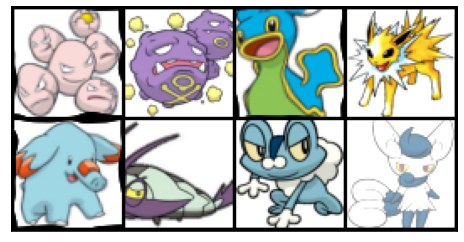

In [ ]:
for images, _ in dataloader:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    images = images.detach()[:64]
    # денормализация
    images = images * normalization_stats[1][0] + normalization_stats[0][0]
    ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    break

## Discriminator

In [ ]:
# Количество цветовых каналов
nc = 3
# размер feature maps
ndf = 64

dcgan_disc = nn.Sequential(
    # input nc x 64 x 64
    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # выход слоя (ndf) x 32 x 32
    nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # выход слоя (ndf*2) x 16 x 16
    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # выход слоя (ndf*4) x 8 x 8
    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # выход слоя (ndf*8) x 4 x 4
    nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

## Generator



In [ ]:
seed_size = 16
# размер Z latent vector
nz = 16
# размер feature maps
ngf = 64

dcgan_gen =  nn.Sequential(
    # input Z
    nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # выход слоя (ngf*8) x 4 x 4
    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # выход слоя (ngf*4) x 8 x 8
    nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # выход слоя (ngf*2) x 16 x 16
    nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # выход слоя (ngf) x 32 x 32
    nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
    nn.Tanh()
    # выход слоя (nc) x 64 x 64
)

In [ ]:
def to_device(data, device):
    """Функция, чтобы отсылать данные на GPU для тренировки"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Инициализируем dataloader"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Возвращаем данные после перемещения их на утройство"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Количество бачей"""
        return len(self.dataloader)


# Проверяем, что мы на видеокарте
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Chillin with GPU")
else:
  #device = torch.device('cuda')
  print("Swith Colab to GPU")

Chillin with GPU


In [ ]:
# Создаем DataLoader, который будет грузить данные на GPU
dev_dataloader = DeviceDataLoader(dataloader, device)

## Обучение
В качестве лосса будем использовать ```binary_cross_entropy```

In [ ]:
BCE = nn.BCELoss()

def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    real_predictions = discriminator(real_pokemon) 
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 
    real_loss = BCE(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()  
    # Нашумим чтобы скормить генератору
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)  
    # Сгенерим фейков
    fake_pokemon = generator(latent_batch)  
    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 
    gen_loss = BCE(gen_predictions, gen_targets)  
    gen_score = torch.mean(gen_predictions).item() 
    # Обновляем веса
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()
    # Генерим фейков
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) 
    loss = BCE(disc_predictions, targets)
    # Обновляем веса
    loss.backward()
    gen_optimizer.step()
    return loss.item()

In [ ]:
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
def save_results(index, latent_batch):
    ''' Сохряем, что сгенерилось на каждой эпохе '''
    # Генерим покемона
    fake_pokemon = generator(latent_batch)
    # Название файла для записи
    fake_file = "result-image-{0:0=4d}.png".format(index)
    # Денормализация
    fake_pokemon = fake_pokemon * normalization_stats[1][0] + normalization_stats[0][0]
    # Сохраняем
    save_image(fake_pokemon, os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")

#### Подключим TensorBoard, чтобы трекать обучение

In [ ]:
#pip install torch torchvision
writer = SummaryWriter()

In [ ]:
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()
    
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epochs):
        for real_img, _ in tqdm(dev_dataloader):
            # Обучаем дискриминатор
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            # Обучаем генератор
            gen_loss = train_generator(gen_optimizer)
        
        # Собираем результаты
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)

        # Записываем в TensorBoard
        writer.add_scalar("gen_loss", disc_loss, epoch)
        writer.add_scalar("disc_loss", gen_loss, epoch)
        writer.add_scalar("gen_score", real_score, epoch)
        writer.add_scalar("dicc_score", gen_score, epoch)
        
        # Выводим лосс и скоры
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        # Сохраняем что сгенерили
        save_results(epoch + start_idx, fixed_latent_batch)

        # И сохраняем картинки в TensorBoard
        fake_pokemon = generator(fixed_latent_batch)
        fake_pokemon = fake_pokemon * normalization_stats[1][0] + normalization_stats[0][0]
        grid = torchvision.utils.make_grid(fake_pokemon)
        writer.add_image('generated_images', grid, global_step=epoch)

    return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:
discriminator = dcgan_disc
generator = dcgan_gen

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [ ]:
learning_rate = 0.0028
epochs = 100

In [ ]:
history = train(epochs, learning_rate)

  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [1/100], gen_loss: 2.5953, disc_loss: 0.5317, real_score: 0.0886, gen_score: 0.8660
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [2/100], gen_loss: 2.2316, disc_loss: 0.8323, real_score: 0.4323, gen_score: 0.8310
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [3/100], gen_loss: 5.5837, disc_loss: 0.5354, real_score: 0.0633, gen_score: 0.9740
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [4/100], gen_loss: 1.1261, disc_loss: 2.5123, real_score: 0.7835, gen_score: 0.9487
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [5/100], gen_loss: 2.3981, disc_loss: 0.3977, real_score: 0.0441, gen_score: 0.9356
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [6/100], gen_loss: 2.7736, disc_loss: 0.5689, real_score: 0.0052, gen_score: 0.7588
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [7/100], gen_loss: 4.5140, disc_loss: 0.5950, real_score: 0.0661, gen_score: 0.7940
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [8/100], gen_loss: 5.0304, disc_loss: 0.4562, real_score: 0.1287, gen_score: 0.8874
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [9/100], gen_loss: 4.2717, disc_loss: 0.6205, real_score: 0.0099, gen_score: 0.7998
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [10/100], gen_loss: 5.1807, disc_loss: 0.4584, real_score: 0.0276, gen_score: 0.8875
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [11/100], gen_loss: 1.3754, disc_loss: 0.4807, real_score: 0.1475, gen_score: 0.9345
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [12/100], gen_loss: 1.0609, disc_loss: 0.5401, real_score: 0.0262, gen_score: 0.8670
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [13/100], gen_loss: 2.6193, disc_loss: 0.6116, real_score: 0.0195, gen_score: 0.7894
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [14/100], gen_loss: 4.4545, disc_loss: 0.6323, real_score: 0.0327, gen_score: 0.8511
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [15/100], gen_loss: 3.0235, disc_loss: 0.4741, real_score: 0.1355, gen_score: 0.9350
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [16/100], gen_loss: 3.4189, disc_loss: 0.4216, real_score: 0.0485, gen_score: 0.9105
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [17/100], gen_loss: 3.9073, disc_loss: 0.4612, real_score: 0.0283, gen_score: 0.8365
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [18/100], gen_loss: 3.8010, disc_loss: 0.6207, real_score: 0.1761, gen_score: 0.9911
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [19/100], gen_loss: 2.7109, disc_loss: 0.3221, real_score: 0.0513, gen_score: 0.9032
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [20/100], gen_loss: 3.8687, disc_loss: 0.5503, real_score: 0.0263, gen_score: 0.8009
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [21/100], gen_loss: 3.9729, disc_loss: 0.4379, real_score: 0.0126, gen_score: 0.9574
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [22/100], gen_loss: 2.8138, disc_loss: 0.3513, real_score: 0.1074, gen_score: 0.9404
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [23/100], gen_loss: 3.2723, disc_loss: 0.4442, real_score: 0.1281, gen_score: 0.9576
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [24/100], gen_loss: 5.0580, disc_loss: 0.3900, real_score: 0.0411, gen_score: 0.9826
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [25/100], gen_loss: 2.8119, disc_loss: 0.5124, real_score: 0.0237, gen_score: 0.8897
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [26/100], gen_loss: 3.3986, disc_loss: 0.6249, real_score: 0.1961, gen_score: 0.9784
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [27/100], gen_loss: 3.1191, disc_loss: 0.6341, real_score: 0.3195, gen_score: 0.9899
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [28/100], gen_loss: 3.4661, disc_loss: 0.4371, real_score: 0.0807, gen_score: 0.9672
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [29/100], gen_loss: 3.5852, disc_loss: 0.4607, real_score: 0.0409, gen_score: 0.9112
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [30/100], gen_loss: 2.5124, disc_loss: 0.3878, real_score: 0.0625, gen_score: 0.9388
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [31/100], gen_loss: 2.4352, disc_loss: 0.4350, real_score: 0.0132, gen_score: 0.9553
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [32/100], gen_loss: 1.7646, disc_loss: 0.4808, real_score: 0.1326, gen_score: 0.9305
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [33/100], gen_loss: 2.8800, disc_loss: 0.4276, real_score: 0.1021, gen_score: 0.8966
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [34/100], gen_loss: 1.7038, disc_loss: 0.4916, real_score: 0.1227, gen_score: 0.8718
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [35/100], gen_loss: 3.1100, disc_loss: 0.5182, real_score: 0.0189, gen_score: 0.9016
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [36/100], gen_loss: 2.8506, disc_loss: 1.1004, real_score: 0.5237, gen_score: 0.9912
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [37/100], gen_loss: 1.9863, disc_loss: 0.4364, real_score: 0.1310, gen_score: 0.9254
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [38/100], gen_loss: 3.1232, disc_loss: 0.4746, real_score: 0.0311, gen_score: 0.9539
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [39/100], gen_loss: 3.2542, disc_loss: 0.4044, real_score: 0.0798, gen_score: 0.9437
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [40/100], gen_loss: 1.4164, disc_loss: 0.5301, real_score: 0.0086, gen_score: 0.8749
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [41/100], gen_loss: 3.7873, disc_loss: 0.3744, real_score: 0.0552, gen_score: 0.9420
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [42/100], gen_loss: 2.7721, disc_loss: 0.4046, real_score: 0.0359, gen_score: 0.9683
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [43/100], gen_loss: 5.0292, disc_loss: 0.5816, real_score: 0.0071, gen_score: 0.9008
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [44/100], gen_loss: 2.5124, disc_loss: 0.4280, real_score: 0.0638, gen_score: 0.9714
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [45/100], gen_loss: 3.4391, disc_loss: 0.4050, real_score: 0.0284, gen_score: 0.9853
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [46/100], gen_loss: 4.5641, disc_loss: 0.5149, real_score: 0.0315, gen_score: 0.9828
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [47/100], gen_loss: 4.7703, disc_loss: 0.4314, real_score: 0.0077, gen_score: 0.8735
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [48/100], gen_loss: 3.6967, disc_loss: 0.5194, real_score: 0.0221, gen_score: 0.9838
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [49/100], gen_loss: 2.8493, disc_loss: 0.4376, real_score: 0.0482, gen_score: 0.8776
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [50/100], gen_loss: 3.3190, disc_loss: 0.5101, real_score: 0.0320, gen_score: 0.9694
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [51/100], gen_loss: 3.1024, disc_loss: 0.5789, real_score: 0.0319, gen_score: 0.7882
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [52/100], gen_loss: 3.4018, disc_loss: 0.3848, real_score: 0.0240, gen_score: 0.9384
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [53/100], gen_loss: 2.7834, disc_loss: 0.4843, real_score: 0.1902, gen_score: 0.8823
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [54/100], gen_loss: 3.7036, disc_loss: 0.5639, real_score: 0.0584, gen_score: 0.9288
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [55/100], gen_loss: 1.9480, disc_loss: 0.4087, real_score: 0.1038, gen_score: 0.9629
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [56/100], gen_loss: 2.8440, disc_loss: 0.5775, real_score: 0.1975, gen_score: 0.9623
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [57/100], gen_loss: 3.2996, disc_loss: 0.4158, real_score: 0.0222, gen_score: 0.9510
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [58/100], gen_loss: 2.8296, disc_loss: 0.4523, real_score: 0.0886, gen_score: 0.9683
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [59/100], gen_loss: 2.6807, disc_loss: 0.4002, real_score: 0.0945, gen_score: 0.9486
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [60/100], gen_loss: 2.0620, disc_loss: 0.5391, real_score: 0.1208, gen_score: 0.9745
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [61/100], gen_loss: 2.2905, disc_loss: 0.4300, real_score: 0.1276, gen_score: 0.9612
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [62/100], gen_loss: 2.4917, disc_loss: 0.4500, real_score: 0.0565, gen_score: 0.9810
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [63/100], gen_loss: 4.7962, disc_loss: 0.4994, real_score: 0.1520, gen_score: 0.9924
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [64/100], gen_loss: 3.0628, disc_loss: 0.3966, real_score: 0.1043, gen_score: 0.9310
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [65/100], gen_loss: 2.7586, disc_loss: 0.4753, real_score: 0.1166, gen_score: 0.9080
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [66/100], gen_loss: 2.4753, disc_loss: 0.4353, real_score: 0.0752, gen_score: 0.9619
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [67/100], gen_loss: 4.3486, disc_loss: 0.4175, real_score: 0.0740, gen_score: 0.9709
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [68/100], gen_loss: 2.7020, disc_loss: 0.6624, real_score: 0.3228, gen_score: 0.9660
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [69/100], gen_loss: 3.8776, disc_loss: 0.4280, real_score: 0.1195, gen_score: 0.9043
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [70/100], gen_loss: 2.6959, disc_loss: 0.4216, real_score: 0.0475, gen_score: 0.9764
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [71/100], gen_loss: 2.7519, disc_loss: 0.3594, real_score: 0.0790, gen_score: 0.9759
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [72/100], gen_loss: 1.8623, disc_loss: 0.4453, real_score: 0.0639, gen_score: 0.9091
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [73/100], gen_loss: 0.9962, disc_loss: 0.5785, real_score: 0.2651, gen_score: 0.9619
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [74/100], gen_loss: 2.9531, disc_loss: 0.4469, real_score: 0.0434, gen_score: 0.9627
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [75/100], gen_loss: 2.5661, disc_loss: 0.4743, real_score: 0.0737, gen_score: 0.9740
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [76/100], gen_loss: 3.2687, disc_loss: 0.4575, real_score: 0.1043, gen_score: 0.9594
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [77/100], gen_loss: 2.9489, disc_loss: 0.4072, real_score: 0.0792, gen_score: 0.9700
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [78/100], gen_loss: 3.2589, disc_loss: 0.5074, real_score: 0.1803, gen_score: 0.9826
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [79/100], gen_loss: 1.8342, disc_loss: 0.5246, real_score: 0.0934, gen_score: 0.9829
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [80/100], gen_loss: 3.4566, disc_loss: 0.3757, real_score: 0.0372, gen_score: 0.9601
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [81/100], gen_loss: 2.6645, disc_loss: 0.4096, real_score: 0.1099, gen_score: 0.9596
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [82/100], gen_loss: 1.4471, disc_loss: 0.4301, real_score: 0.1090, gen_score: 0.9047
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [83/100], gen_loss: 4.0882, disc_loss: 0.4027, real_score: 0.1102, gen_score: 0.9340
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [84/100], gen_loss: 3.6656, disc_loss: 0.5268, real_score: 0.0317, gen_score: 0.9814
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [85/100], gen_loss: 2.3693, disc_loss: 0.3960, real_score: 0.0221, gen_score: 0.8900
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [86/100], gen_loss: 2.5586, disc_loss: 0.4415, real_score: 0.0207, gen_score: 0.9518
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [87/100], gen_loss: 3.4036, disc_loss: 0.3187, real_score: 0.0848, gen_score: 0.9702
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [88/100], gen_loss: 1.9992, disc_loss: 0.5098, real_score: 0.2089, gen_score: 0.9464
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [89/100], gen_loss: 3.8684, disc_loss: 0.4203, real_score: 0.0302, gen_score: 0.9490
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [90/100], gen_loss: 2.5952, disc_loss: 0.4813, real_score: 0.1929, gen_score: 0.9198
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [91/100], gen_loss: 2.3318, disc_loss: 0.3809, real_score: 0.0436, gen_score: 0.9211
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [92/100], gen_loss: 3.4519, disc_loss: 0.4416, real_score: 0.0085, gen_score: 0.9406
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [93/100], gen_loss: 3.1910, disc_loss: 0.3706, real_score: 0.0133, gen_score: 0.9631
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [94/100], gen_loss: 2.2400, disc_loss: 0.5112, real_score: 0.0508, gen_score: 0.9658
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [95/100], gen_loss: 3.3633, disc_loss: 0.5009, real_score: 0.0581, gen_score: 0.9828
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [96/100], gen_loss: 2.8256, disc_loss: 0.4620, real_score: 0.1439, gen_score: 0.9324
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [97/100], gen_loss: 3.4134, disc_loss: 0.4685, real_score: 0.1145, gen_score: 0.9465
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [98/100], gen_loss: 3.1756, disc_loss: 0.5214, real_score: 0.1403, gen_score: 0.9715
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [99/100], gen_loss: 3.4013, disc_loss: 0.4976, real_score: 0.0217, gen_score: 0.9400
Result Saved!


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch [100/100], gen_loss: 2.1047, disc_loss: 0.5017, real_score: 0.0968, gen_score: 0.9691
Result Saved!


In [ ]:
# закрываем writer TensorBoard-а
writer.close()
%tensorboard --logdir=runs

### Сохраняем TensorBoard
Доступ к экспериментам можно получить по ссылкам: [50 эпох](https://tensorboard.dev/experiment/ltajKpFnRnG9xoclg8v5zw/#scalars) и [100 эпох](https://tensorboard.dev/experiment/SBqmdE1BT2uRkD8T3mrFKw/#scalars). К сожалению, с веб-версии TensorBoard-а нет доступа к сгенерированным картинкам, но есть при запуске с ноутбука. (но картинки можно посмотреть в гифках ☺️)

In [ ]:
!tensorboard dev upload \
  --logdir runs/ \
  --name "Pokemon Generation via DCGAN (100 epochs)" \
  --description "Learning progress represented with scores and losses of generator and discriminator. Added pictures generated on each epoch." \
  --one_shot

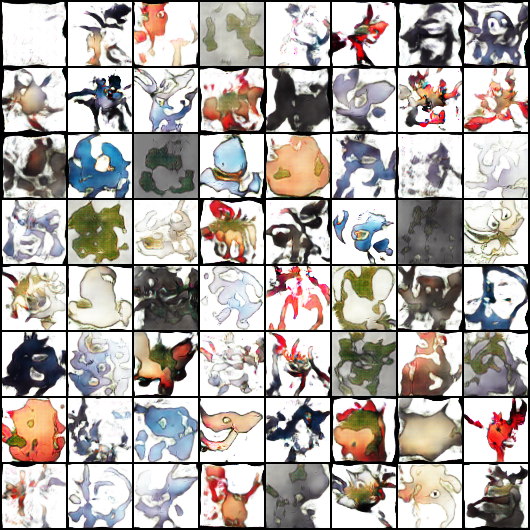

In [ ]:
# put your image path
Image('./results/result-image-0050.png')

## Сохраняем модель

In [ ]:
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

#### Предобученные модели ($50$ и $100$ эпох) можно скачать [здесь](https://drive.google.com/drive/folders/1N3PIDPy60qruqCeyqI-4teDcdi533rxf?usp=share_link). 

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: 
                f.write(chunk)

# откуда сохраняем с драйва
file_id_100 = '1S6a3ia8zOxG8KcCqnwfQiXdVA-iQX0zI' # gen 100
file_id_50 = '1F-7FzCFoyhpSktXaidDdrqPXFZSHwAUD' # gen 50

# куда сохраняем в коллабе
destination100 = 'gen_100e.pth'
destination50 = 'gen_50e.pth'

download_file_from_google_drive(file_id_100, destination100) 
download_file_from_google_drive(file_id_50, destination50) 

In [ ]:
device = torch.device("cuda")

# загружаем предобученную модель на 100 эпох
dcgan_100e = generator
dcgan_100e.load_state_dict(torch.load(destination100))
dcgan_100e.to(device)

# загружаем предобученную модель на 50 эпох
dcgan_50e = generator
dcgan_50e.load_state_dict(torch.load(destination50))
dcgan_50e.to(device)

Sequential(
  (0): ConvTranspose2d(16, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)
# куда сохраним сгенерированные фотографии
IMG_PATH_100 = "generated_image100.png"
IMG_PATH_50 = "generated_image50.png"

def generate_with_pretrained_model(file_name, pretrained_model, latent_batch=fixed_latent_batch):
    fake_pokemon = pretrained_model(fixed_latent_batch)
    # Название файла для записи
    fake_file = file_name
    # Денормализация
    fake_pokemon = fake_pokemon * normalization_stats[1][0] + normalization_stats[0][0]
    # Сохраняем
    save_image(fake_pokemon, fake_file, nrow=8)
    print("Result saved in " + file_name)

# генерим новых покемонов
generate_with_pretrained_model(file_name=IMG_PATH_100, pretrained_model=dcgan_100e)
generate_with_pretrained_model(file_name=IMG_PATH_50, pretrained_model=dcgan_50e)

Result saved in generated_image100.png
Result saved in generated_image50.png


Выведем то, что сохранили

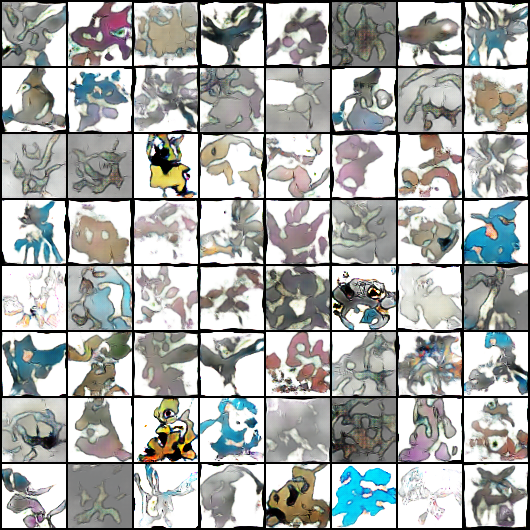

In [ ]:
Image(IMG_PATH_100)

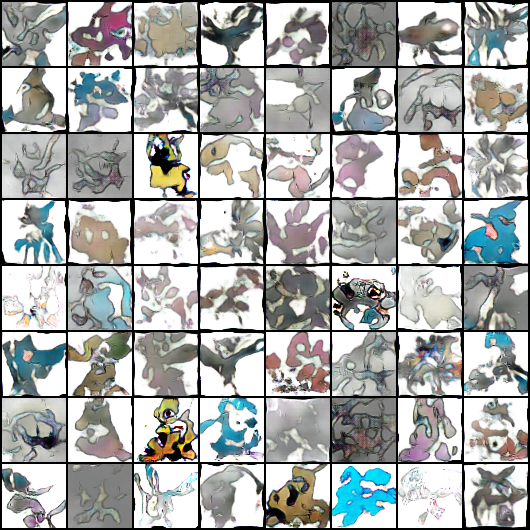

In [ ]:
Image(IMG_PATH_50)